# HABSlib + BrainOS : 105
In this fifth notebook, we will learn the workflow of how to search for EEG biomarkers using the BrainOS APIs.

### What is a biomarker
A **biomarker** is a measurable indicator of some biological state or condition ([Wikipedia](https://en.wikipedia.org/wiki/Biomarker)). They can be **predictive**, when they serve as a method of predicting (often clinical) outcomes, **diagnostic**, when they serve a role in narrowing down diagnosis, or **prognostic**, when they provide information about the patients overall outcome.      
More practically, to build a biomarker, you need to find indicative features of the biological state you want to detect. A **feature** is an individual measurable property or characteristic of a phenomenon ([Wikipedia](https://en.wikipedia.org/wiki/Feature_(machine_learning))). Often, just one feature will not be enough to reliably identify the target biological state. This is why you need to explore the feature space.

### How we do it
For this session, we will use the HABSlib EEG simulator to create an EEG signal of known features representing a biological state (like *"drowsy"*). Then we will use the BrainOS API to
- extract a whole set of features,
- assess their significance,
- and rank those that are more indicative of the EEG state.      

At the end of this procedure, we should have a better understanding of the relevant features for our phenomenon.

Please, refer to the documentation of [HABSlib](https://olocufier.github.io/HABSlib/) for further details.

In [11]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb

from datetime import timedelta
from datetime import timezone 
import datetime 

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


## Login
As usual, the first thing to do to start a session with the HABS BrainOS is to handshake.

In [12]:
# hb.handshake(base_url="http://135.237.144.125/", user_id='8d60e8693a9560ee57e8eba3')
hb.handshake(base_url="http://0.0.0.0/", user_id='8d60e8693a9560ee57e8eba3')


       HUMAN        AUGMENTED        BRAIN         SYSTEMS    
   ---------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░  
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░ 
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░  
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░ 
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░  
   ---------------------------------------------------------- 
   version: 0.1.46

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Synthetic data for drowsiness
Drowsiness is the feeling of being sleepy. It is often characterized in the EEG community with relatively higher power spectral amplitudes in the Delta and Theta bands ([Lechat et al. 2022](https://pubmed.ncbi.nlm.nih.gov/35554584/), [Xavier et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32515890/)). We take these features as examples and not as actually or fully identifying drowsiness.

With the HABSlib EEG simulator, we can easily introduce relative power amplitudes for the different bands.

To simulate a protocol in which a baseline EEG is acquired for 5 seconds and it is followed by 15 seconds of focused state, we will use a sequence of presets.     
The dummy preset `relaxed` is characterized by relativey high alpha band amplitude (Delta=0.2, Theta=0.2, Alpha=0.7, Beta=0.3, Gamma=0.2; these values are relative to the overall amplitude computed by the HABSlib dummy EEG generator).     
The dummy preset `focus` is characterized by relativey high beta band amplitude (Delta=0.1, Theta=0.1, Alpha=0.5, Beta=0.8, Gamma=0.4).     

In [13]:
# BrainOS uses as timestamp of UTC timezone (standard in BrainOS)
sessiondate = datetime.datetime.now(timezone.utc)
sessiondate = sessiondate.replace(tzinfo=timezone.utc) 
print(sessiondate)

# Acquire synthetic EEG data
session_id = hb.acquire_send_raw(
    user_id='8d60e8693a9560ee57e8eba3', 
    date=sessiondate.strftime('%Y-%m-%dT%H:%M:%SZ'), 
    board="SYNTHETIC", 
    extra={
        "eeg_channels": 16,
        "sampling_rate": 250,
        "noise": 1,
        "artifacts": 0.01,
        "modulation_type": 'random',
        "power_law_slope": 0.8,
        "sequence": [("relaxed",5),("alert",15)]
    },
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)

2024-08-17 21:59:15.962797+00:00
Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66c11d3377780292579c7513 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-17T21:59:15Z', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...


In [14]:
# Retrieve the data for the session
results = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id=session_id)
eeg_data = np.array(results)
print(eeg_data.shape)

Retrieved data successfully.
(16, 5000)


#### Baseline ('relaxed') PSD

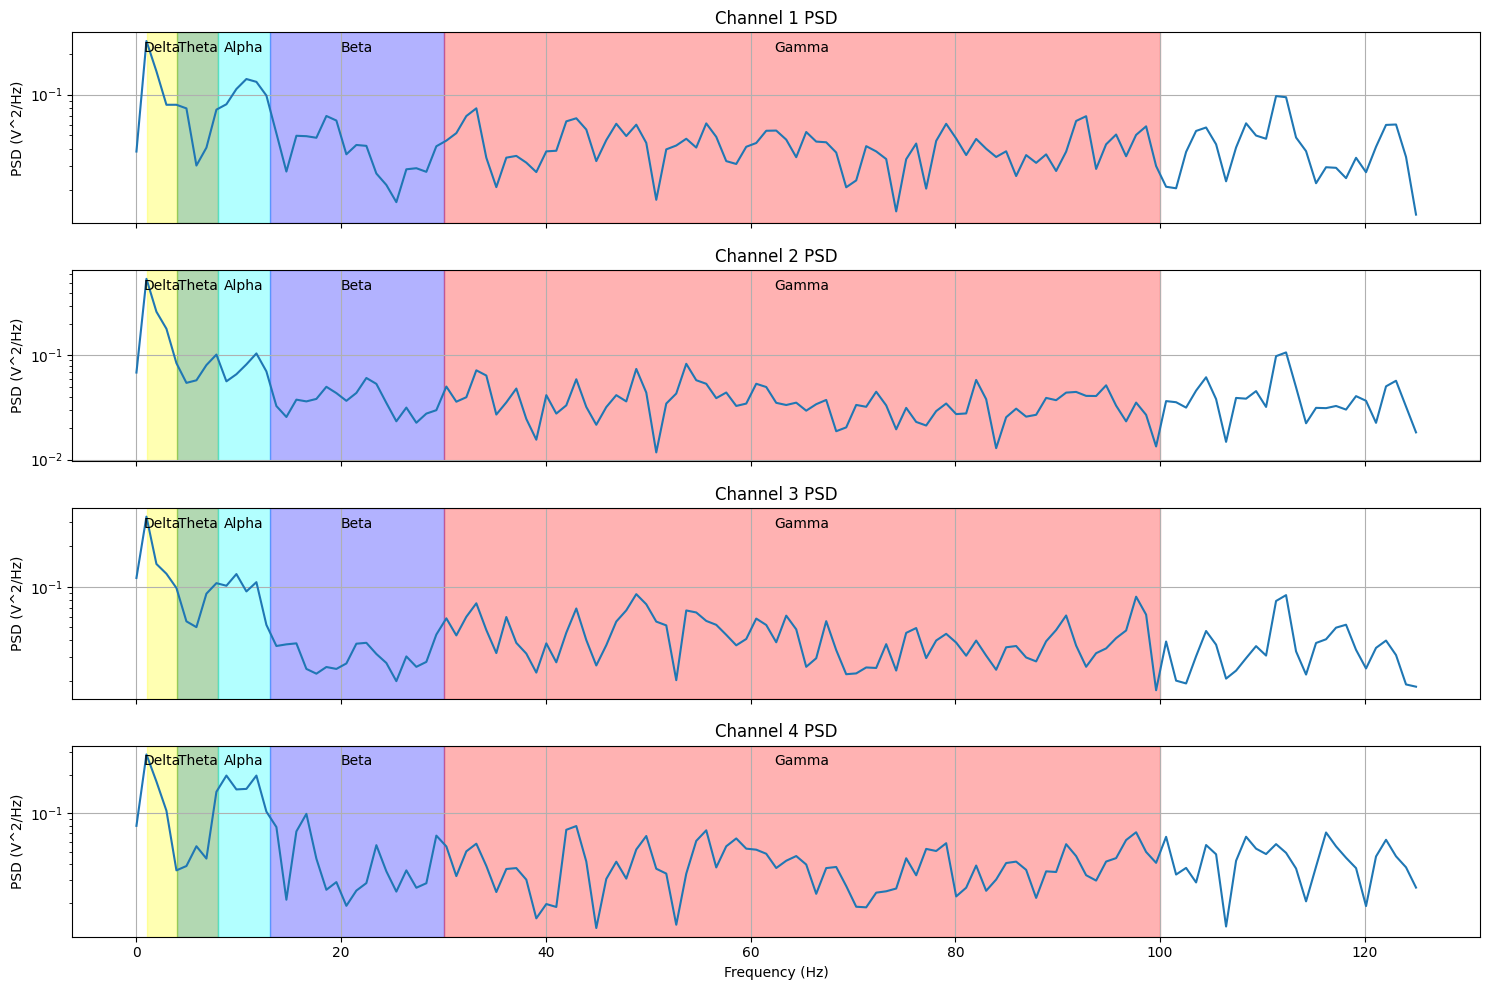

In [15]:
samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(eeg_data[i][:1250], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)
    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

#### Task ('focus') PSD

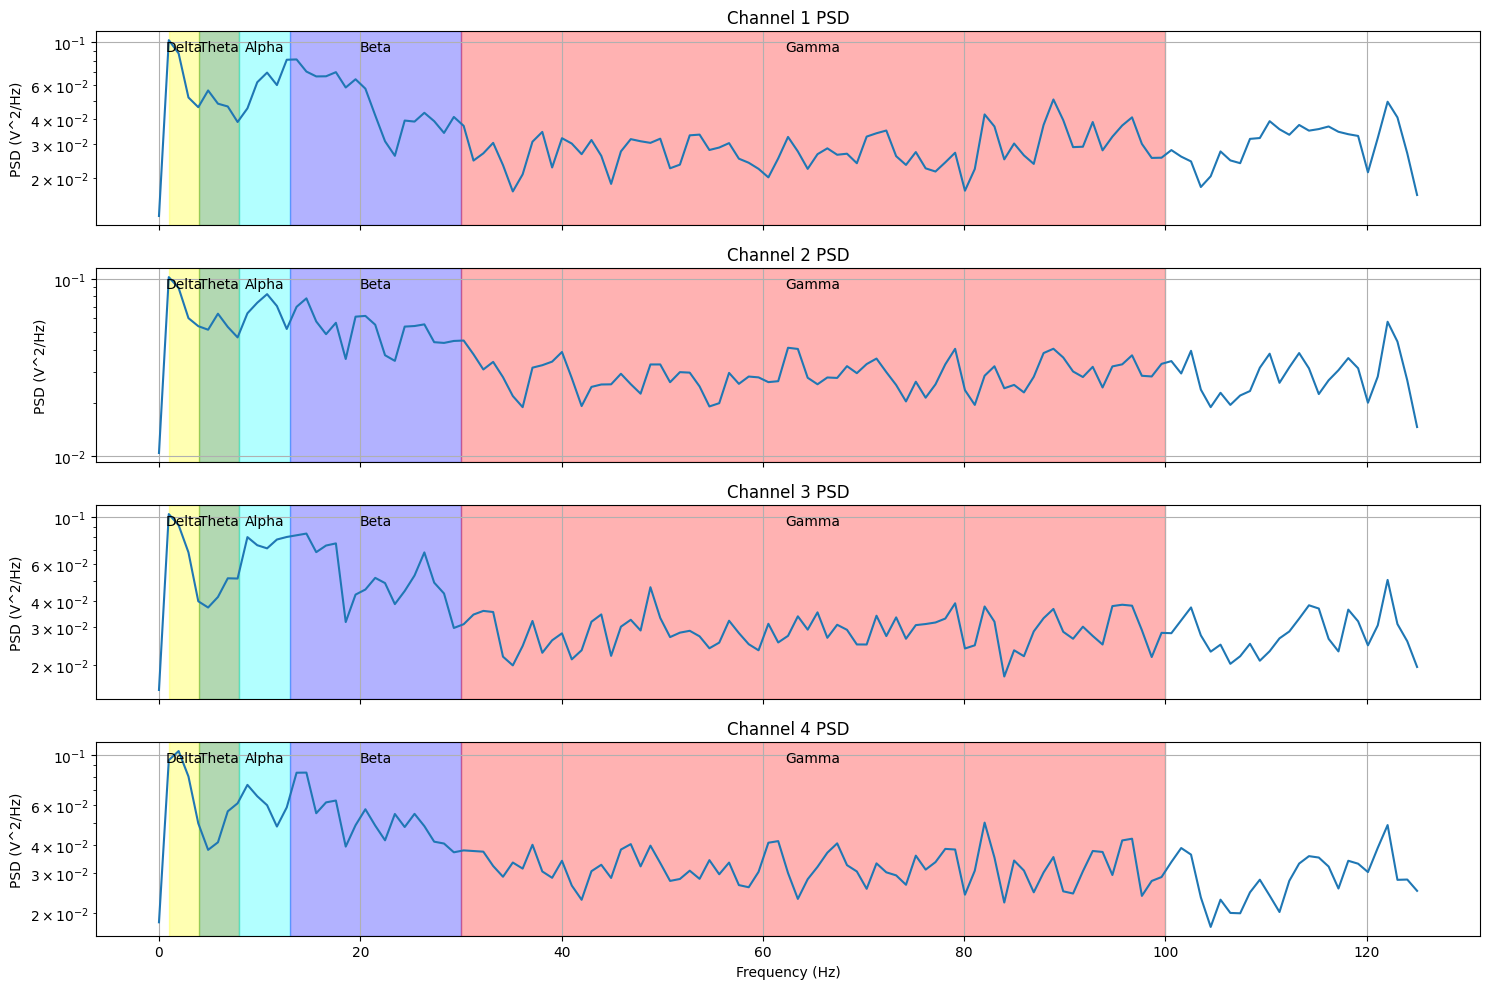

In [16]:
samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(eeg_data[i][1250:], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)
    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

### Tag session data as 'baseline' or 'target'
The two conditions above will be the bases for our analysis. We tag them to be more easily accessed in the analysis steps below.      
We use the BrainOS built-in tagging endpoint.

In [17]:
# tagging 'baseline' interval
startt = sessiondate
endt = startt+timedelta(0,5) # seconds
print(startt.strftime('%Y-%m-%dT%H:%M:%SZ'))
print(startt.timestamp())
print(endt.strftime('%Y-%m-%dT%H:%M:%SZ'))
print(endt.timestamp())
interval_id = hb.create_tagged_interval(
    user_id    = '8d60e8693a9560ee57e8eba3',
    session_id = session_id,
    start_time = startt.strftime('%Y-%m-%dT%H:%M:%SZ'),
    end_time   = endt.strftime('%Y-%m-%dT%H:%M:%SZ'),
    tags = [{"tag": "baseline"}] #, "properties": {"severity": "high"}}]
)

2024-08-17T21:59:15Z
1723931955.962797
2024-08-17T21:59:20Z
1723931960.962797
{'user_id': '8d60e8693a9560ee57e8eba3', 'session_id': '66c11d3377780292579c7513', 'start_time': '2024-08-17T21:59:15Z', 'end_time': '2024-08-17T21:59:20Z', 'tags': [{'tag': 'baseline'}], 'channel_ids': []}
Metadata validation successful!
Tagged interval successfully created.


In [18]:
# tagging 'target' interval
startt = startt+timedelta(0,5) # 5 seconds
endt = startt+timedelta(0,15) # 15 seconds
print(sessiondate)
print(startt.strftime('%Y-%m-%dT%H:%M:%SZ'))
print(startt.timestamp())
print(endt.strftime('%Y-%m-%dT%H:%M:%SZ'))
print(endt.timestamp())
interval_id = hb.create_tagged_interval(
    user_id    = '8d60e8693a9560ee57e8eba3',
    session_id = session_id,
    start_time = startt.strftime('%Y-%m-%dT%H:%M:%SZ'),
    end_time   = endt.strftime('%Y-%m-%dT%H:%M:%SZ'),
    tags = [{"tag": "target"}] #, "properties": {"severity": "high"}}]
)

2024-08-17 21:59:15.962797+00:00
2024-08-17T21:59:20Z
1723931960.962797
2024-08-17T21:59:35Z
1723931975.962797
{'user_id': '8d60e8693a9560ee57e8eba3', 'session_id': '66c11d3377780292579c7513', 'start_time': '2024-08-17T21:59:20Z', 'end_time': '2024-08-17T21:59:35Z', 'tags': [{'tag': 'target'}], 'channel_ids': []}
Metadata validation successful!
Tagged interval successfully created.


## Get baseline and target data
In this example session, getting the tagged data is overkill, it would be easy to just split the array `eeg_data` retrieved above. But there will be other cases in which multiple tags will be present. Here we adopt the tagging functions to showcase their usage.

In [19]:
# Step 1: get the intervals    
data_baseline = hb.get_tagged_interval_data(
    user_id = "8d60e8693a9560ee57e8eba3",
    session_id = session_id,
    tag="baseline"
)
if data_baseline:
    data_baseline=np.array(data_baseline)
    print(data_baseline.shape)
    print(data_baseline)

data_target = hb.get_tagged_interval_data(
    user_id = "8d60e8693a9560ee57e8eba3",
    session_id = session_id,
    tag="target"
)
if data_target:
    data_target=np.array(data_target)
    print(data_target.shape)
    print(data_target)


Successfully retrieved data for tag 'baseline'.
(16, 1250)
[[ 3.29426201e+00  2.07063259e+00  2.38362072e-01 ...  1.56022263e+00
   5.29676053e-01  3.60463054e-01]
 [ 4.11066329e+00  4.22660293e+00  1.59766399e+00 ... -2.52769240e+00
  -4.15004074e-01 -1.60687471e+00]
 [-1.27413977e+00  3.81319257e-01 -2.17098785e+00 ... -4.35887586e+00
  -3.02607393e+00 -1.38071645e+00]
 ...
 [ 1.71954888e+00  1.73268402e+00 -3.38359341e-01 ...  1.13302094e-01
  -4.81736271e-01 -1.81469701e+00]
 [ 1.47366785e+00  7.53855511e-01 -2.20514416e+00 ...  1.76661519e+00
  -1.35138091e+00 -1.55984700e+00]
 [ 5.68910512e+02  6.50489053e+01  2.00377882e+02 ...  1.72975762e+02
  -1.43503930e+02  6.88208904e+02]]
Successfully retrieved data for tag 'target'.
(16, 3750)
[[-1.66592269e-01 -2.04980435e+00 -2.60151647e+00 ...  1.59822788e+00
   1.69317488e+00  4.55237869e-01]
 [ 2.22397304e+00 -1.53726255e+00  1.38718647e-01 ...  3.76311160e-01
   3.26155749e-01 -2.22841592e-01]
 [ 7.94921865e-01  1.91624684e+00  3.7

## Feature extraction and assessment
In this session, we will iterate over the data, directly on the server, using BrainOS feature extraction APIs.     

We will use the API pipeline `/filtering/artifact/<feature>/<tag>` for some available features:
- mean
- std
- var
- kurtosis
- skew
- delta
- theta
- alpha
- beta
- gamma
- zerocrossing
- hjorthmobility
- hjorthcomplexity
- entropy
- fractaldim
- hurst
- selfaffinity

We will extract the same feature for the `baseline` tagged interval and the `target` interval. 

In this example, for each feature, we compute the ratio between the `baseline` and the `target` intervals to assess changes. This comparison will highlight how the feature evolves during the session. Then we will assess the significance of the current feature by looking at the standard deviation and percentile of its value during the `target` interval with respect to the `baseline` interval.

We will store these values in a dictionary and plot a summary. We will also use these vallues to rank the features.

In [24]:
from scipy.interpolate import interp1d

# Step 2: Iterate over the features
# Feature map
features = ['mean','std','var','kurtosis', 'skew', 
            'delta', 'theta', 'alpha', 'beta', 'gamma', 
            'zerocrossings', 'hjorthmobility', 'entropy', 'hurst']
            # out, for the moment, to be checked:
            # 'correlatedim', 'fractaldim', 'hjorthcomplexity', 'selfaffinity', 'asymmetry', 'correlation', 'phaselocking'

feature_results = {}

# parameters for the filtering
b_notch, a_notch = signal.iirnotch(50., 2.0, 250)
sos = signal.butter(10, [1, 40], 'bandpass', fs=250, output='sos')

for i, feature in enumerate(features):
    print(f"\n\n---------------------------\nFeature {i}: {feature}\n")
    
    # Step 3: Extract the feature
    _, processed_baseline = hb.process_session_pipe(
        pipeline=f"/filtering/artifact/{feature}",
        params={
            "filtering": {'a_notch': a_notch.tolist(),'b_notch': b_notch.tolist(),'sos': sos.tolist()},
            "artifact":{},
            f"{feature}":{'window':250} # data points
        },
        user_id='8d60e8693a9560ee57e8eba3', 
        date=datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
        existing_session_id = session_id,
        existing_tagged_interval='baseline',
        session_type="Feature Extraction", 
        tags=[f"{feature}"]
    )
    processed_baseline = np.array(processed_baseline)
    print(processed_baseline.shape) 

    _, processed_target = hb.process_session_pipe(
        pipeline=f"/filtering/artifact/{feature}",
        params={
            "filtering": {'a_notch': a_notch.tolist(),'b_notch': b_notch.tolist(),'sos': sos.tolist()},
            "artifact":{},
            f"{feature}":{'window':250} # data points
        },
        user_id='8d60e8693a9560ee57e8eba3', 
        date=datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
        existing_session_id = session_id,
        existing_tagged_interval='target',
        session_type="Feature Extraction", 
        tags=[f"{feature}"]
    )
    processed_target = np.array(processed_target)
    print(processed_target.shape) 

    averaged_baseline = np.mean(processed_baseline, axis=1, keepdims=True)
    
    ratio = processed_target / averaged_baseline

    feature_results[feature] = ratio




---------------------------
Feature 0: mean

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-18 00:18:50', 'existing_session_id': '66c11d3377780292579c7513', 'session_type': '[On 66c11d3377780292579c7513]: Feature Extraction', 'session_tags': ['mean']}
Metadata validation successful!
Session successfully created.
(16, 5)
{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-18 00:18:53', 'existing_session_id': '66c11d3377780292579c7513', 'session_type': '[On 66c11d3377780292579c7513]: Feature Extraction', 'session_tags': ['mean']}
Metadata validation successful!
Session successfully created.
(16, 15)


---------------------------
Feature 1: std

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-18 00:18:55', 'existing_session_id': '66c11d3377780292579c7513', 'session_type': '[On 66c11d3377780292579c7513]: Feature Extraction', 'session_tags': ['std']}
Metadata validation successful!
Session successfully created.
(16, 5)
{'user_id': '8d60e8693

### Visualize the results
the results are 15 points, because 3750 sampling points with windows of 250 data points gives 15 (which is the amount of seconds of the recording), for each channel.

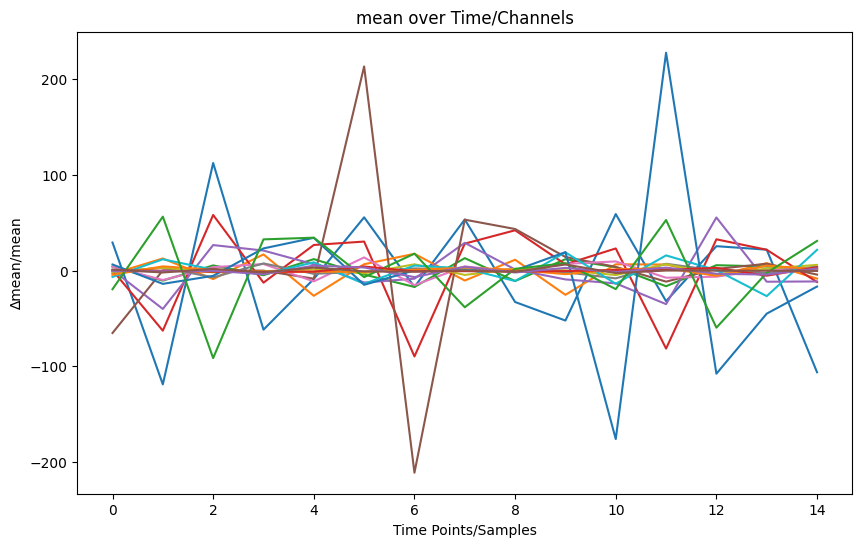

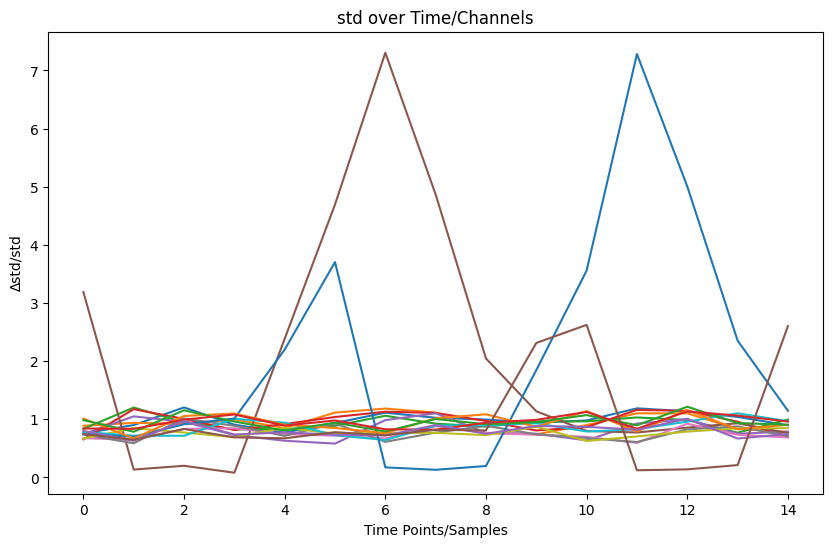

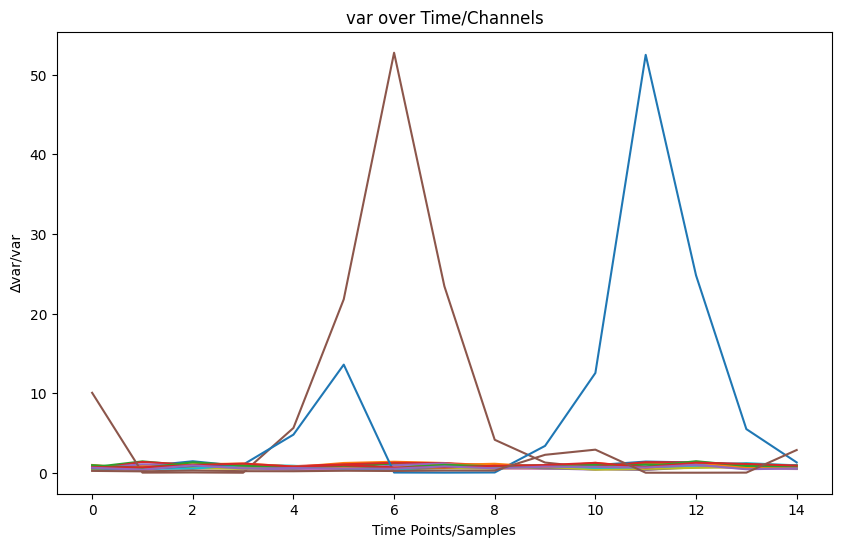

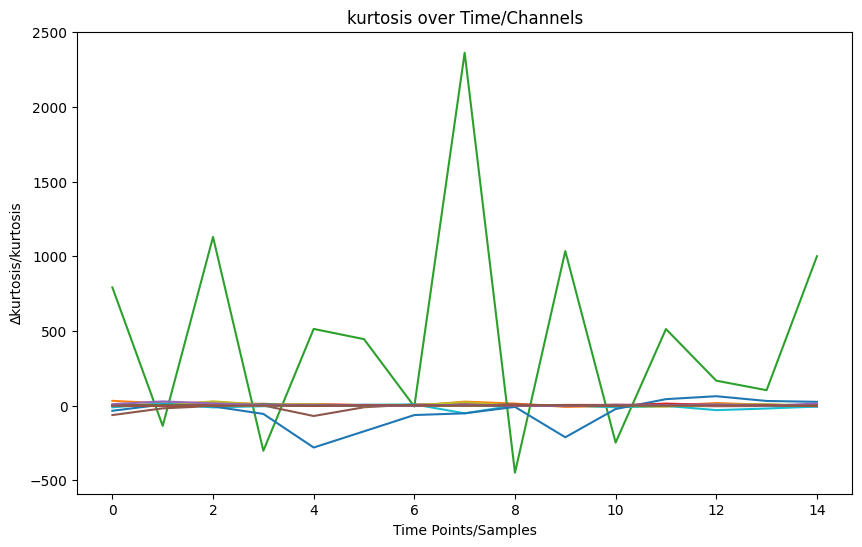

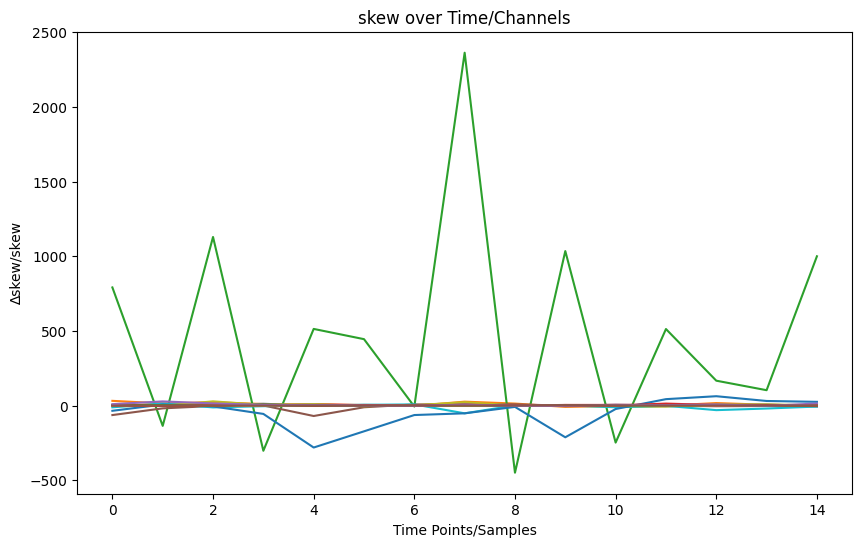

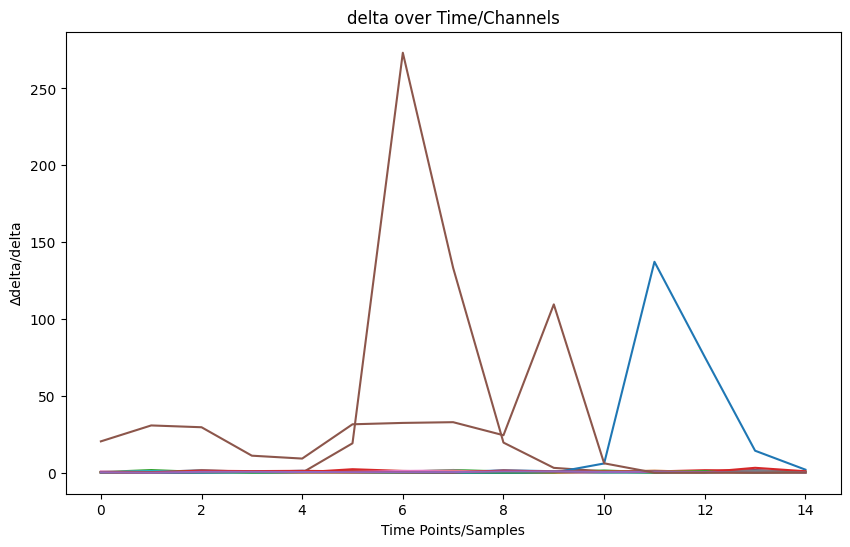

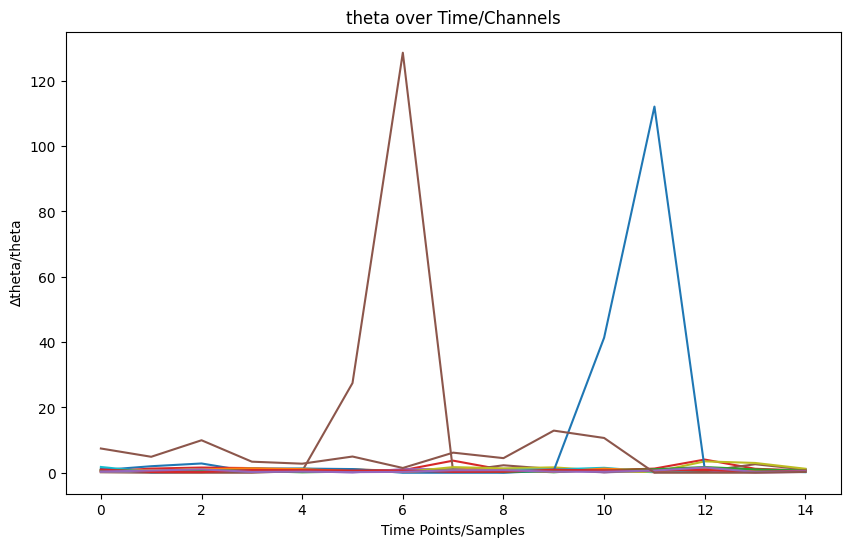

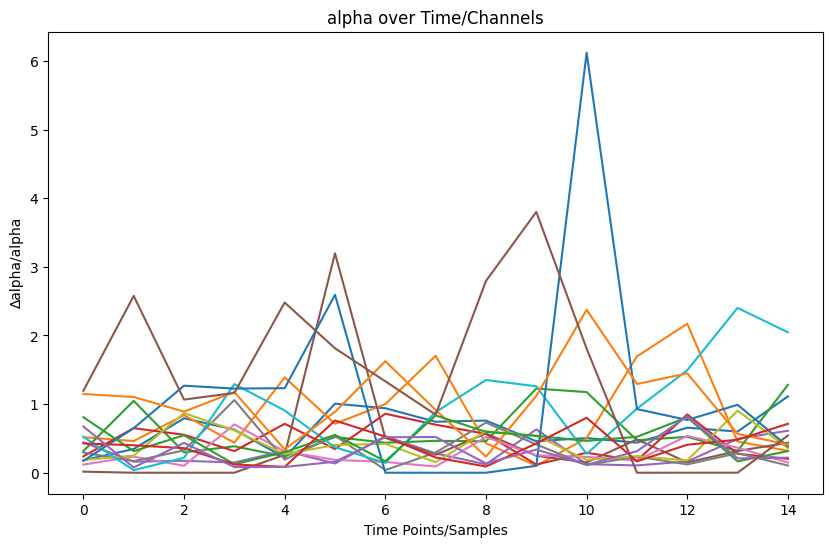

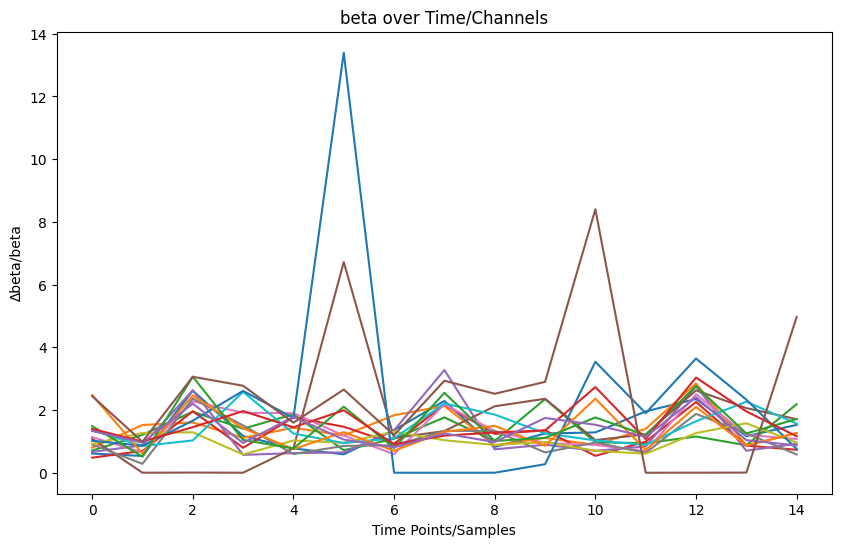

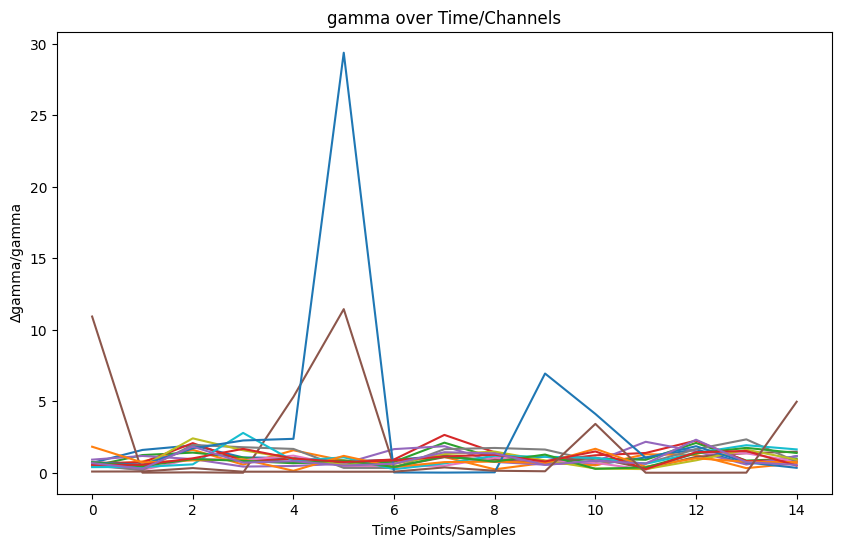

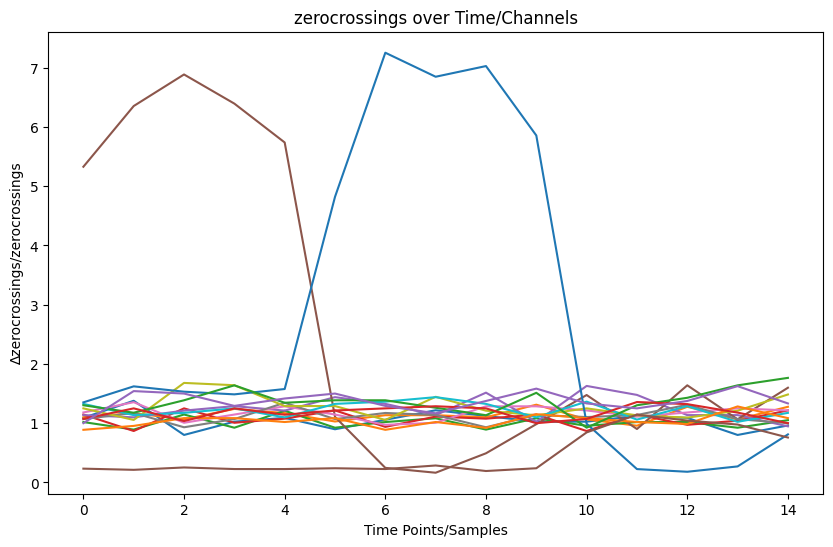

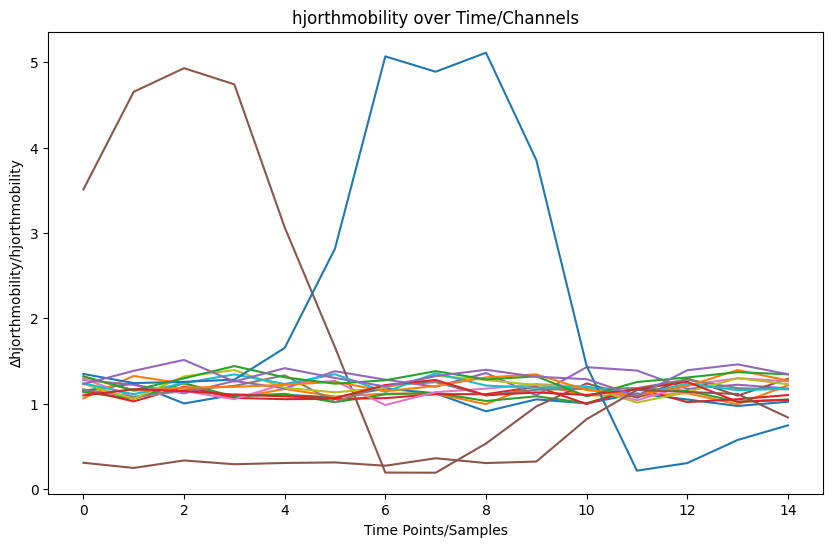

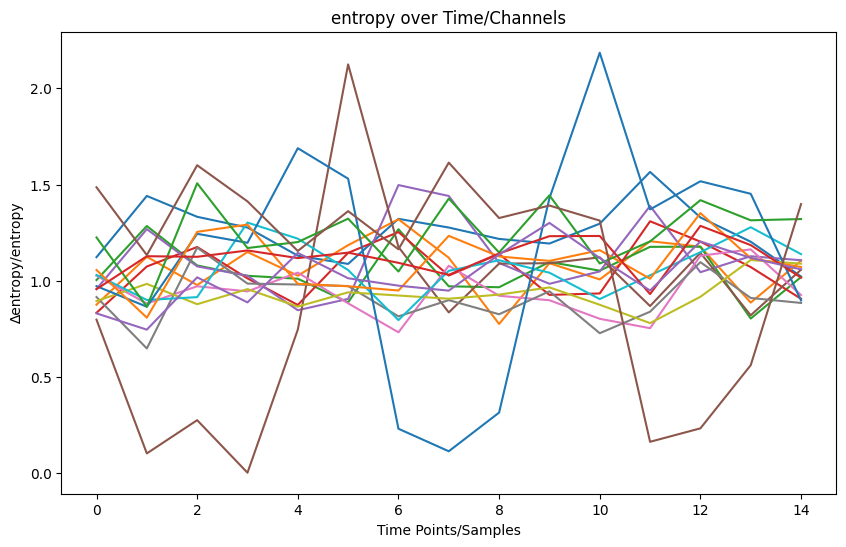

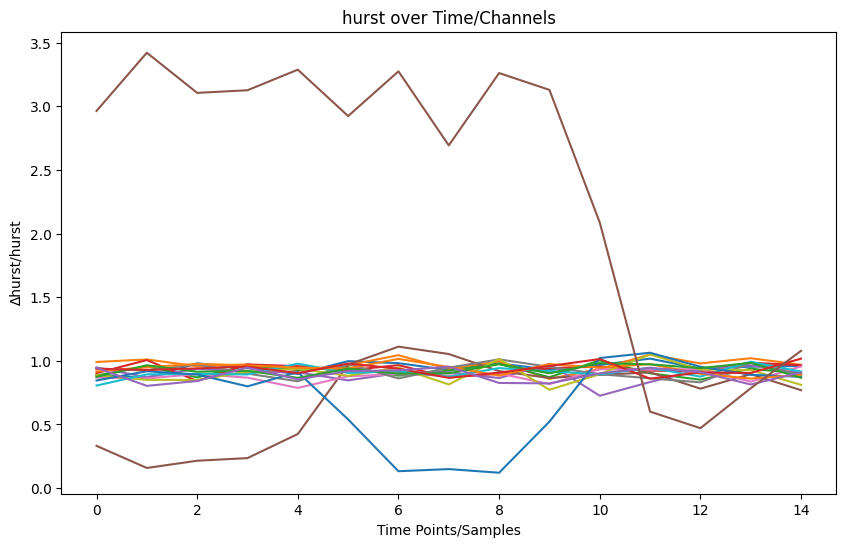

In [25]:
# print(feature_results)
for feature_name, feature_data in feature_results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(feature_data.T)
    plt.title(f'{feature_name} over Time/Channels')
    plt.xlabel('Time Points/Samples')
    plt.ylabel(f'∆{feature_name}/{feature_name}')
    plt.show()


### Rank features 
We will now order the features by their maximal variance with respect to baseline.     
This reduced number of features will be the beginning of our biomarker for the target EEG state.

We perform ranking by